In [1]:
from tensorflow import keras
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import pickle

2022-04-29 22:29:03.646740: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-29 22:29:03.646811: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Load & Preprocess Data

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [3]:
x_train = x_train / 255.0
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))

x_test = x_test / 255.0
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [4]:
print(f'''
    Input and Output Shapes
    x_train :: {x_train.shape}
    x_test  :: {x_test.shape}
    y_train :: {y_train.shape}
    y_test  :: {y_test.shape}
    
    dtypes :: {x_train.dtype} {x_test.dtype}
''')


    Input and Output Shapes
    x_train :: (60000, 784)
    x_test  :: (10000, 784)
    y_train :: (60000,)
    y_test  :: (10000,)
    
    dtypes :: float64 float64



# Building the Autoencoder

Steps for building:
1. Train layer by layer (max of four layers

In [5]:
# Train first layer of autoencoder
N_FEATURES = 28 * 28
enc_flatten = keras.layers.Input(shape=(784,), name='input_layer')
enc_1 = keras.layers.Dense(units=N_FEATURES / 2, activation='relu', name='enc_1')(enc_flatten)
dec_out = keras.layers.Dense(units=N_FEATURES, activation='sigmoid', name='decoder_output')

model_1 = keras.Model(enc_flatten, dec_out(enc_1))
model_1.compile(optimizer='adam', loss='mean_squared_error')
model_1.fit(x_train, x_train, epochs=50, batch_size=256, verbose=0)
enc_1.trainable = False
model_1.save('./models/ae_one_layers/')

2022-04-29 22:29:09.591400: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-29 22:29:09.591559: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-29 22:29:09.591631: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-J42MFLO): /proc/driver/nvidia/version does not exist
2022-04-29 22:29:09.592209: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-29 22:30:33.403220: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequenc

INFO:tensorflow:Assets written to: ./models/ae_one_layers/assets


In [6]:
# Train second layer
enc_2 = keras.layers.Dense(units=N_FEATURES / 2 / 2, activation='relu', name='enc_2')(enc_1)
dec_out = keras.layers.Dense(units=N_FEATURES, activation='sigmoid', name='decoder_output')
dec_2 = keras.layers.Dense(units=N_FEATURES / 2, activation='relu', name='dec_2')

dec_2 = dec_2(enc_2)
model_2 = keras.Model(enc_flatten, dec_out(dec_2))
model_2.compile(optimizer='adam', loss='mean_squared_error')
model_2.fit(x_train, x_train, epochs=50, batch_size=256, verbose=0)
enc_2.trainable = False
model_2.save('./models/ae_two_layers/')

INFO:tensorflow:Assets written to: ./models/ae_two_layers/assets


In [7]:
# Train third layer
enc_3 = keras.layers.Dense(units=N_FEATURES / 2 / 2 / 2, activation='relu', name='enc_3')(enc_2)
dec_out = keras.layers.Dense(units=N_FEATURES, activation='sigmoid', name='decoder_output')
dec_3 = keras.layers.Dense(units=N_FEATURES / 2 / 2, activation='relu', name='dec_3')
dec_2 = keras.layers.Dense(units=N_FEATURES / 2, activation='relu', name='dec_2')

dec_3 = dec_3(enc_3)
dec_2 = dec_2(dec_3)
model_3 = keras.Model(enc_flatten, dec_out(dec_2))
model_3.compile(optimizer='adam', loss='mean_squared_error')
model_3.fit(x_train, x_train, epochs=50, batch_size=256, verbose=0)
enc_3.trainable = False
model_3.save('./models/ae_three_layers/')

INFO:tensorflow:Assets written to: ./models/ae_three_layers/assets


In [8]:
# Train final layer
enc_4 = keras.layers.Dense(units=N_FEATURES / 2 / 2 / 2 / 2, activation='relu', name='enc_4')(enc_3)
dec_out = keras.layers.Dense(units=N_FEATURES, activation='sigmoid', name='decoder_output')
dec_3 = keras.layers.Dense(units=N_FEATURES / 2 / 2, activation='relu', name='dec_3')
dec_2 = keras.layers.Dense(units=N_FEATURES / 2, activation='relu', name='dec_2')
dec_4 = keras.layers.Dense(units=N_FEATURES / 2 / 2 / 2, activation='relu', name='dec_4')

dec_4 = dec_4(enc_4)
dec_3 = dec_3(dec_4)
dec_2 = dec_2(dec_3)
model_4 = keras.Model(enc_flatten, dec_out(dec_2))
model_4.compile(optimizer='adam', loss='mean_squared_error')
model_4.fit(x_train, x_train, epochs=50, batch_size=256, verbose=0)
enc_4.trainable = False
model_4.save('./models/ae_four_layers/')

INFO:tensorflow:Assets written to: ./models/ae_four_layers/assets


In [9]:
aes = [
    keras.models.load_model('./models/ae_one_layers/'),
    keras.models.load_model('./models/ae_two_layers/'),
    keras.models.load_model('./models/ae_three_layers/'),
    keras.models.load_model('./models/ae_four_layers/')
]

In [10]:
for ae in aes:
    print(ae.summary())
    predictions = ae.predict(x_test)
    print(f'MSE :: {mean_squared_error(predictions, x_test)}')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 784)]             0         
                                                                 
 enc_1 (Dense)               (None, 392)               307720    
                                                                 
 decoder_output (Dense)      (None, 784)               308112    
                                                                 
Total params: 615,832
Trainable params: 615,832
Non-trainable params: 0
_________________________________________________________________
None
MSE :: 0.0019098897194830579
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 784)]             0         
                                                                 
 enc

In [11]:
label_mapper = {
    0: 'T-Shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandals',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boots'
}

In [12]:
img_idxs = [ np.where(y_test == i)[0][0] for i in range(10) ]

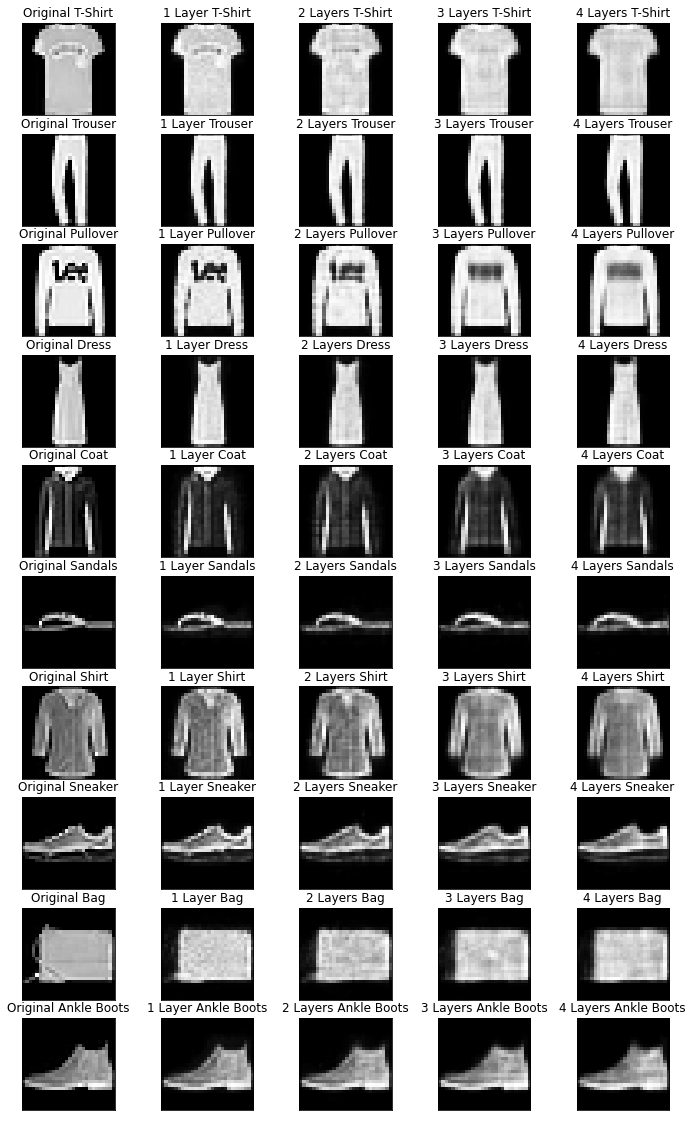

<Figure size 432x288 with 0 Axes>

In [14]:
n = 10
plt.figure(figsize=(12, 20))
for i, img in enumerate(img_idxs):
    # display original
    ax = plt.subplot(n, 5, i * 5 + 1)
    plt.imshow(x_test.reshape(-1,28,28,1)[img][:,:,0])
    plt.title(f'Original {label_mapper[i]}')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(n, 5, i * 5 + 2)
    plt.imshow(aes[0].predict(x_test).reshape(-1,28,28,1)[img][:,:,0])
    plt.title(f'1 Layer {label_mapper[i]}')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(n, 5, i * 5 + 3)
    plt.imshow(aes[1].predict(x_test).reshape(-1,28,28,1)[img][:,:,0])
    plt.title(f'2 Layers {label_mapper[i]}')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(n, 5, i * 5 + 4)
    plt.imshow(aes[2].predict(x_test).reshape(-1,28,28,1)[img][:,:,0])
    plt.title(f'3 Layers {label_mapper[i]}')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(n, 5, i * 5 + 5)
    plt.imshow(aes[3].predict(x_test).reshape(-1,28,28,1)[img][:,:,0])
    plt.title(f'4 Layers {label_mapper[i]}')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

plt.show()
plt.savefig('./plots/og_reconstructed.png')